In [1]:
'''
参考:
https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/
Task:
根据前132个月的旅行数据预测最后12个月的旅行数据
'''

import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## Dataset and Problem Definition

我们先来打印看一下Seaborn library里的内容

In [2]:
sns.get_dataset_names()

D:\program files\Anaconda3\lib\site-packages\seaborn\utils.py:384: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 384 of the file D:\program files\Anaconda3\lib\site-packages\seaborn\utils.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  gh_list = BeautifulSoup(http)


['anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'exercise',
 'flights',
 'fmri',
 'gammas',
 'geyser',
 'iris',
 'mpg',
 'penguins',
 'planets',
 'tips',
 'titanic']

我们会用到其中的flights数据集，让我们加载数据集看看它的结构

In [3]:
flight_data = sns.load_dataset("flights")
flight_data.head()

,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132
3,1949,April,129
4,1949,May,121


数据有144列，有就是说包含了12年的旅行数据

In [4]:
flight_data.shape

(144, 3)

让我们画出每个月游客出行的频率，下面的代码增加了默认的plot的大小：

In [5]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

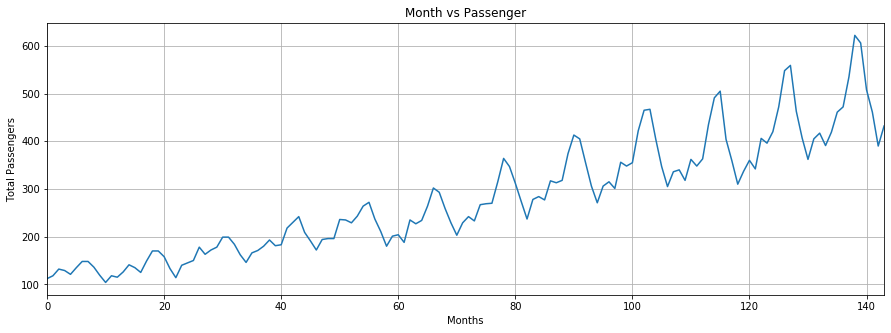

In [75]:
plt.title("Month vs Passenger")
plt.ylabel('Total Passengers')
plt.xlabel('Months')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'])
plt.savefig('data.jpg')

## Data Preprocessing

数据集中每一列的数据类型是object

In [33]:
flight_data.columns

Index(['year', 'month', 'passengers'], dtype='object')

首先我们把object的数据类型改为float

In [34]:
all_data = flight_data['passengers'].values.astype(float)
print(all_data)

[112. 118. 132. 129. 121. 135. 148. 148. 136. 119. 104. 118. 115. 126.
 141. 135. 125. 149. 170. 170. 158. 133. 114. 140. 145. 150. 178. 163.
 172. 178. 199. 199. 184. 162. 146. 166. 171. 180. 193. 181. 183. 218.
 230. 242. 209. 191. 172. 194. 196. 196. 236. 235. 229. 243. 264. 272.
 237. 211. 180. 201. 204. 188. 235. 227. 234. 264. 302. 293. 259. 229.
 203. 229. 242. 233. 267. 269. 270. 315. 364. 347. 312. 274. 237. 278.
 284. 277. 317. 313. 318. 374. 413. 405. 355. 306. 271. 306. 315. 301.
 356. 348. 355. 422. 465. 467. 404. 347. 305. 336. 340. 318. 362. 348.
 363. 435. 491. 505. 404. 359. 310. 337. 360. 342. 406. 396. 420. 472.
 548. 559. 463. 407. 362. 405. 417. 391. 419. 461. 472. 535. 622. 606.
 508. 461. 390. 432.]


我们接下来要把数据集分为训练集和测试集，前132个月的数据为训练集，后12个月的数据为测试集

In [35]:
test_data_size = 12
train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

In [36]:
print(len(train_data))
print(len(test_data))

132
12


因为前几年和后几年的数据差异较大，我们需要对数据做Normalization, 把Normalization的范围设置为(0, 1)更准确，因为人数没有负数

In [56]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
train_data_normalized = scaler.fit_transform(train_data.reshape(-1, 1))# 1 Column

In [57]:
print(train_data_normalized[:5])
print(train_data_normalized[-5:])

[[0.01758242]
 [0.03076923]
 [0.06153846]
 [0.05494505]
 [0.03736264]]
[[1.        ]
 [0.78901099]
 [0.66593407]
 [0.56703297]
 [0.66153846]]


In [58]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)


In [59]:
train_data_normalized.shape

torch.Size([132])

最后的预处理步骤是把训练集转化为序列，并添加相应标签。
我们可以选择任意的序列长度，但因为一年有12个月，在这里我们设置为12

In [60]:
train_window = 12 # 序列长度

接下来我们要定义函数create_inout_sequences，函数接收原始数据，输出一个列表元组。
第一个Element：12个月的旅行数据
第二个Element：12 + 1st month的数据

In [61]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L - tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq, train_label))
    return inout_seq

In [62]:
# The length of train_inout_seq is 120
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [63]:
for seq, label in train_inout_seq[:1]:
    print(seq.view(12, 1, -1).shape)

torch.Size([12, 1, 1])


## Creating LSTM Model

In [64]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        
        self.linear = nn.Linear(hidden_layer_size, output_size)
        
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))
        
    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        
        return predictions[-1]

接下来我们实例化object，因为我们要解决分类问题，所以我们使用cross entropy loss

In [65]:
model = LSTM() 
loss_function = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [66]:
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


## Training the Model

In [67]:
epochs = 150
for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))
        
        y_pred = model(seq)
        
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
        
    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00123795
epoch:  26 loss: 0.00513289
epoch:  51 loss: 0.00010065
epoch:  76 loss: 0.00133549
epoch: 101 loss: 0.00036098
epoch: 126 loss: 0.00022903
epoch: 149 loss: 0.0001784122


## Making Predictions

In [68]:
fut_pred = 12
test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[0.5626373887062073, 0.5230769515037537, 0.6637362837791443, 0.6417582631111145, 0.694505512714386, 0.8087912201881409, 0.9758241772651672, 1.0, 0.7890110015869141, 0.6659340858459473, 0.5670329928398132, 0.6615384817123413]


In [69]:
model.eval()
for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())
    

In [70]:
test_inputs[fut_pred:]

[0.7801020741462708,
 0.7216687798500061,
 0.7321386337280273,
 0.7743334174156189,
 0.7899345755577087,
 0.8520410656929016,
 0.9417868256568909,
 1.0279442071914673,
 1.0572963953018188,
 1.0019012689590454,
 0.8970534801483154,
 0.7762197852134705]

由于我们之前对训练数据做了归一化，现在预测数据也被归一化了。我们需要把归一化的预测数据转化为原数据

In [71]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:]).reshape(-1, 1))
print(actual_predictions)

[[458.94644374]
 [432.35929483]
 [437.12307835]
 [456.32170492]
 [463.42023188]
 [491.67868489]
 [532.51300567]
 [571.71461427]
 [585.06985986]
 [559.86507738]
 [512.15933347]
 [457.18000227]]


In [72]:
x = np.arange(132, 144, 1)
print(x)

[132 133 134 135 136 137 138 139 140 141 142 143]


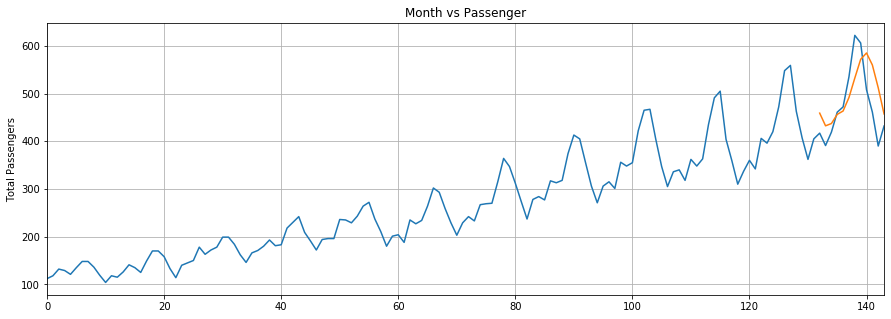

In [76]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'])
plt.plot(x,actual_predictions)
plt.savefig('predict.jpg')
plt.show()

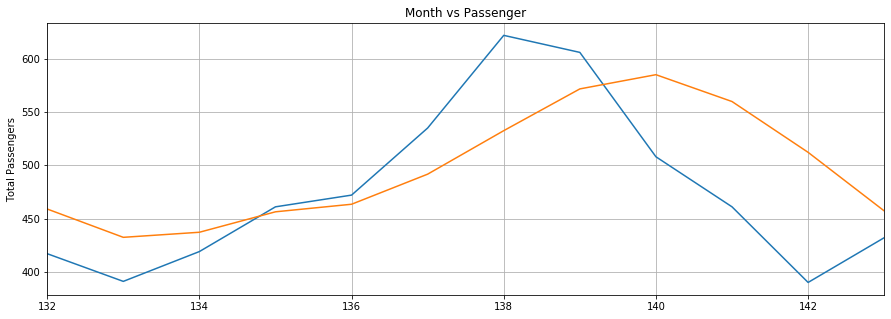

In [77]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(flight_data['passengers'][-train_window:])
plt.plot(x,actual_predictions)
plt.savefig('zoomin.jpg')
plt.show()